# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

C:\Users\mgruz\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mgruz\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

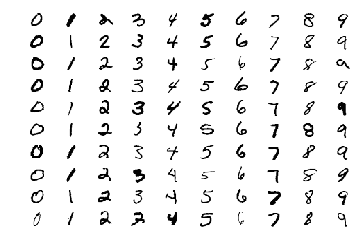

In [3]:
def P1(num_examples):

    ### STUDENT START ###
    # // grab the unique digits from the data in mini train labels in order to get unique digits for the plot
    uniq_number_list = np.unique(mini_train_labels)
    # // instantiate a figure and axes to loop through subplot indices for 10 by 10 digit showcase
    fig, axes = plt.subplots(nrows=num_examples, ncols=len(uniq_number_list))
    # // loop through the integer list
    for uniq_num in uniq_number_list:
        # // this creates a list (length of variable num_examples) of randomly chosen digit arrays inside the mini
        # // train data array corresponding to the value of the integer (label) at the time of the loop
        matrix_list = mini_train_data[np.random.choice(np.where(mini_train_labels == uniq_num)[0], num_examples, replace=False)]
        # // create a sub iteration to loop down rows for plot, it resets every time a new digit is seen
        sub_plot_itr = 0
        for matrix in matrix_list:
            # // this creates a perfect square out of the one dimensional matrix digit information so it can be plotted
            reshape_square_length = int(np.sqrt(matrix.shape[0]))
            use_matrix = np.reshape(matrix, (reshape_square_length, reshape_square_length))
            # // makes a sub plot of the digit depending on which digit and what number of sub_plot_itr you are on
            # // For this question a 10 x 10 matrix is desired
            axes[sub_plot_itr][int(uniq_num)].imshow(use_matrix, cmap='Greys')
            axes[sub_plot_itr][int(uniq_num)].axis('off')
            sub_plot_itr += 1

    plt.show()
    return
    ### STUDENT END ###

# // run def: P1(num_examples)
# // Input : num_examples = how many different versions of the same digit you want to see
# // Output: A: N x M matrix of images of the digit. Each column is its own unique digit, number of rows depends on 
# // num_examples input. Unique digits depends on if the digits exist inside the mini_train_labels data
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
### STUDENT START ###
import collections
import sys

def classifaction_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[2])
        row['recall'] = float(row_data[3])
        row['f1_score'] = float(row_data[4])
        row['support'] = int(row_data[5])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)[['precision','recall','f1_score', 'support']]
    return dataframe


def P2(k_values):
    # // instantiate two dictionaries to save variable values to: difficult_digit_dict saves output from classification_report()
    # // to deliver clean answers to problem; accuracy_dict saves how accurate each prediction is based on K value
    accuracy_dict = {}
    difficult_digit_dict = {}
    for i in range(10):
        difficult_digit_dict[i] = {}
        difficult_digit_dict[i]['precision'] = []
        difficult_digit_dict[i]['recall'] = []
        difficult_digit_dict[i]['f1_score'] = []
    
    # // loop through k_value list : [1, 3, 5, 7, 9]
    for k_val in k_values:
        # // train the model then see how accurate the model is:
        knn = KNeighborsClassifier(n_neighbors=k_val)
        # // instantiate a training set for algorithm learning
        knn.fit(mini_train_data, mini_train_labels)
        # // get the prediction out using KNeighborsClassifier function in scipy and save the predicted labels
        label_prediction = knn.predict(dev_data)
        # // check how many labels are correct
        correct = sum(label_prediction==dev_labels)
        # // make a fraction correct divided total length of labels for an accuracy ratio
        accuracy_dict[k_val] = float(correct) / len(dev_labels)
        # // get report out of classification_report()
        report = classification_report(label_prediction, dev_labels)
        
        # // parse the classification_report() into a dataframe
        df = classifaction_report_csv(report)
        
        # // save key dataframe values into the difficult_digit_dict to deliver clean answers to problem
        for index in df.index:            
            difficult_digit_dict[index]['precision'].append(df.precision[index])
            difficult_digit_dict[index]['recall'].append(df.recall[index])
            difficult_digit_dict[index]['f1_score'].append(df.f1_score[index])
        
        # // answer to second part of prompt: For k=1, show precision, recall, and F1 for each label
        if k_val == 1:
            print "K is set to: " + str(k_val) + " and operating on training_data: mini_train_data and test data: dev_data"
            print report
    
    # // create an ordered dictionary so that when looping through the keys there is an order to the value of k (chronological)
    # // and print out answer to first part of prompt: Report accuracy on the dev set
    ordered_dict = collections.OrderedDict(sorted(accuracy_dict.items())) 
    for key in ordered_dict:
        print "For K = " + str(key) + " the accuracy of dev_data label selection is " + str(ordered_dict[key])
    
    print '\n'
    
    # // loop through difficult_digit_dict keys (digits) and print out information to last part of prompt:
    # // Which is the most difficult digit?
    for key in difficult_digit_dict:
        print "For digit = " + str(key) + " average precision = " + str(np.mean(difficult_digit_dict[key]['precision'])) \
        + " , average recall = " + str(np.mean(difficult_digit_dict[key]['recall'])) +  \
        " , average f1_score = " + str(np.mean(difficult_digit_dict[key]['f1_score']))
    return


# // run def: P2(k_values)
# // Input : k_values = a list of integers that represent value of K in the K-NN algorithm
# // Output: output table of classification_report() function if K is equal to 1;
# // Prints out for each K value the accuracy of prediction of the test data;
# // Information on average precision, average recall, and average f1_scores to decide which digit is the hardest to learn
k_values = [1, 3, 5, 7, 9]
P2(k_values)
### STUDENT END ###

K is set to: 1 and operating on training_data: mini_train_data and test data: dev_data
             precision    recall  f1-score   support

        0.0       0.98      0.91      0.94       107
        1.0       1.00      0.89      0.94       118
        2.0       0.79      0.99      0.88        82
        3.0       0.87      0.77      0.82        97
        4.0       0.82      0.89      0.85        96
        5.0       0.84      0.93      0.88        82
        6.0       0.96      0.94      0.95       100
        7.0       0.92      0.89      0.90       117
        8.0       0.88      0.94      0.91        89
        9.0       0.82      0.78      0.80       112

avg / total       0.89      0.89      0.89      1000

For K = 1 the accuracy of dev_data label selection is 0.888
For K = 3 the accuracy of dev_data label selection is 0.878
For K = 5 the accuracy of dev_data label selection is 0.869
For K = 7 the accuracy of dev_data label selection is 0.865
For K = 9 the accuracy of dev_data

Answer:
Using average f1 data (weighted harmonic mean of the precision and recall) gathered from each digit for the various cases of K, we can see that digit 3 has the lowest average f1 score maing it the most difficult digit to estimate. (Digit 9 is the next most difficult digit)

ANSWER:

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [129]:
import time

def P3(train_sizes):
    
    ## STUDENT START ###
    # // instantiate a dictionary to save variable values to: accuracy_dict which saves accuracy information and time 
    # // to run prediction algorithm  based on different sizes of the training set
    accuracy_dict = {}
    for size in train_sizes:
        # // start the timer before instantiation of data
        accuracy_dict[size] = {}
        start = time.time()
        # // train the model then see how accurate the model is:
        knn = KNeighborsClassifier(n_neighbors=1)
        # // instantiate a training set for algorithm learning, which varies on size based on how much is training data is desired
        knn.fit(train_data[:size], train_labels[:size])
        # // get the prediction out using KNeighborsClassifier function in scipy and save the predicted labels
        label_prediction = knn.predict(dev_data)
        # // check how many labels are correct
        correct = sum(label_prediction==dev_labels)
        # // make a fraction correct divided total length of labels for an accuracy ratio
        accuracy = float(correct) / len(dev_labels)
        # // save accuracy and time values to accuracy_dict
        accuracy_dict[size]['accuracy'] = accuracy
        # // stop the timer after prediction of labels
        accuracy_dict[size]['time'] = time.time() - start
        
    # // create an ordered dictionary so that when looping through the keys there is an order to the value of size of data 
    # // (chronological)and print out answer to prompt: Report accuracy and time
    ordered_dict = collections.OrderedDict(sorted(accuracy_dict.items())) 
    for key in ordered_dict:
        print "For size of data:" + key + " Dev set accuracy = " + str(ordered_dict[key]['accuracy']) + " Time(in seconds) needed for prediction: " + str(ordered_dict[key]['time'])
    
    # // return a dictionary to help get data for P4()
    return ordered_dict

# // run def: P3(train_sizes)
# // Input : train_sizes = a list of integers that represent amount of data feed into the learning part of K-NN algorithm
# // Output: Prints out for each size of the training set the accuracy of prediction of labels and time it took to 
# // create prediction
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
answer_P3_dict = P3(train_sizes)
### STUDENT END ###

TypeError: cannot concatenate 'str' and 'int' objects

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Prediction for sample test size of 60,000 is equal to an accuracy ratio of 1.24307226036


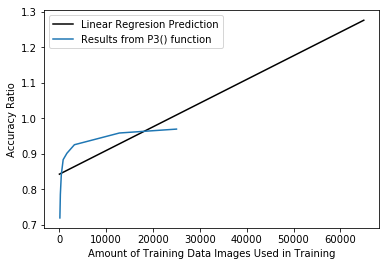

In [6]:
import matplotlib.pyplot as plt
import scipy

def P4():
    ### STUDENT START ###
    # // loop trough answer_P3_dict from problem 3 solution to transform into data structure for LinearRegression()
    size_list = []
    accuracy_list = []
    for key in answer_P3_dict:
        size_list.append(key)
        accuracy_list.append(answer_P3_dict[key]['accuracy'])
        
    # // reshape python lists into numpy arrays for LinearRegression()
    X = np.reshape(np.array(size_list), (len(size_list), 1))
    y = np.array(accuracy_list)
    
    # // Fit the data for linear regression prediction
    linearRegressionP4 = LinearRegression(fit_intercept=True)
    linearRegressionP4.fit(X, y)

    print "Prediction for sample test size of 60,000 is equal to an accuracy ratio of " + str(linearRegressionP4.predict(60000)[0])

    # // Below is just some code to plot two graphs, the actual data (in blue) and the linear regression (black)
    X_predict = np.reshape(np.array(range(0, 70000, 5000)), (len(range(0, 70000, 5000)), 1))
    y_predict = linearRegressionP4.predict(X_predict)

    plt.plot(X_predict, y_predict, color='k', label = 'Linear Regresion Prediction')
    plt.plot(size_list, accuracy_list, label = 'Results from P3() function')
    plt.legend(loc='upper left')
    plt.xlabel('Amount of Training Data Images Used in Training')
    plt.ylabel('Accuracy Ratio')
    return

# // run def: P4()
# // Input : Nothing
# // Output: Prints out prediction from regression of accuracy for 60,000 data points in the training set
P4()

ANSWER:
The above answer to the prompt: What does the regression model predict for n=60000? The prediction is a accuracy ratio of ~1.24. There is an issue here because the accuracy ratio can only go from 0 to 1 in value.

A transformation that can be useful is a logit type transformation. This is because the data is bound in between 0 and 1.

Below function: P4transformed() shows the transformed prediction

In [7]:
def P4transformed():
    ### STUDENT START ###
    # // loop trough answer_P3_dict from problem 3 solution to transform into data structure for LinearRegression()
    size_list = []
    accuracy_list = []
    for key in answer_P3_dict:
        size_list.append(key)
        accuracy_list.append(answer_P3_dict[key]['accuracy'])
        
    # // Transform accuracy data into logit transformation of data
    transformed_accuracies = [np.log(accuracy/(1-accuracy)) for accuracy in accuracy_list]
    # // Transform size data log format of the data
    transformed_size = [np.log(size) for size in size_list]    

    # // reshape python lists into numpy arrays for LinearRegression()
    X = np.reshape(np.array(transformed_size), (len(transformed_size), 1))
    y = np.array(transformed_accuracies)
    
    # // Fit the data for linear regression prediction
    linearRegressionP4a = LinearRegression(fit_intercept=True)
    linearRegressionP4a.fit(X, y)
    
    # // Create Prediction for 60,000 data points
    transformed_prediction = linearRegressionP4a.predict(np.log(60000))
    # // Inverse logit Transformation to get percentage out
    transformed_prediction_final = np.exp(transformed_prediction)/(1+np.exp(transformed_prediction))
    
    print "Prediction for sample test size of 60,000 is equal to an accuracy ratio of " + str(transformed_prediction_final[0])
    

# // run def: P4transformed()
# // Input : Nothing
# // Output: Prints out prediction from regression of accuracy for 60,000 data points in the training set    
P4transformed()

Prediction for sample test size of 60,000 is equal to an accuracy ratio of 0.978514195447


From the transformation, we see we went from ~1.24 predicition to ~ 0.98 prediction for accuracy ratio. This seems a lot more realistic, since accuracy is bounded by 0 to 1 and there seemed to be some convergence towards 1 as you increased the sample size in P3.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]




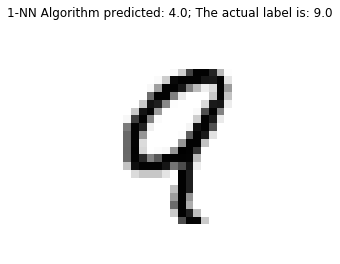

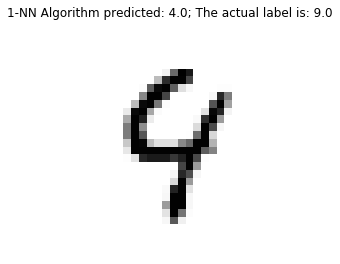

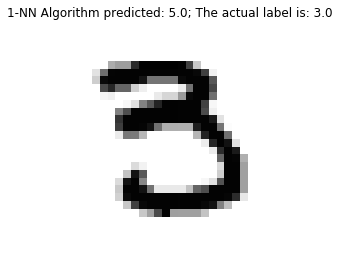

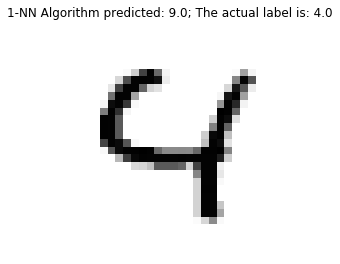

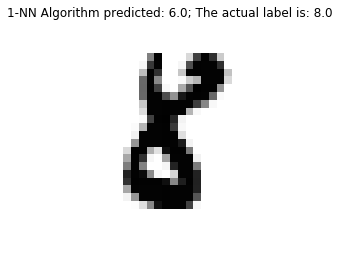

In [8]:
def P5(number_wrong):

    ### STUDENT START ###
    # // train the model with K = 1 and then see how accurate the model is:
    knn = KNeighborsClassifier(n_neighbors=1)
    # // instantiate a training set for algorithm learning
    knn.fit(mini_train_data,mini_train_labels)
    # // get the prediction out using KNeighborsClassifier function in scipy and save the predicted labels
    label_prediction = knn.predict(dev_data)
    # // print the confusion_matrix
    print(confusion_matrix(dev_labels, label_prediction))
    print "\n"
    # // each column represents the digit (0 to 9) the diagnol represents correct predictions. If there is data in the column
    # // not on the diagnol then the column digit was mistaken for the row integer.
    # // Ex. [2,0] = 4. Column 0 is represents the digit 0. Row 2 represents the digit 2. So there were 4 zeros that were 
    # // mistaken for a 2

    ### STUDENT END ###

    # // find number_wrong anmount of digits that were predicted wrong and store it in the list called image_list
    image_list = np.random.choice(np.where(label_prediction!=dev_labels)[0], number_wrong, replace=False)

    # // loop through image_list and reshape the array to perfect square to plot a mis-labelled digit
    for index in image_list:
        reshape_square_length = int(np.sqrt(dev_data[index].shape[0]))
        use_matrix = np.reshape(dev_data[index], (reshape_square_length, reshape_square_length))
        actual_label = dev_labels[index]
        predicted_label = label_prediction[index]
        fig = plt.figure()
        plt.imshow(use_matrix, cmap='Greys')
        plt.title('1-NN Algorithm predicted: ' + str(predicted_label) + "; The actual label is: " + str(actual_label))
        plt.axis('off')

# // run def: P5(number_wrong)
# // Input : number_wrong = how many images to show example of blurring
# // Output: Prints out confusion_matrix and number_wrong of wrong digits predicted
P5(5)

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [9]:
### STUDENT START ###
def P6(matrix_list):
    # // amount of rows and columns per matrix array
    reshape_square_length = 28
    # // instantiate list to put output matrix (blurred) list into 
    output_matrix = []
    # // loop through each matrix of data in input matrix list
    for use_matrix in matrix_list:  
        # // reshape 1D array into square matrix
        use_matrix = np.reshape(np.array(use_matrix), (reshape_square_length, reshape_square_length))
        # // start count of individual digit matrix row        
        row_index = 0
        while row_index < reshape_square_length:
            # // start count of individual digit matrix column  
            column_index = 0
            # // instantiate an empty element list to know which digit elements to average with
            element_dict = {}
            while column_index < reshape_square_length:
                # // element_0 is the current digit element
                # // element_1 through element_8 are adjacent digit element information used for averaging
                element_dict['element_0'] = {"row": row_index, "column": column_index}
                element_dict['element_1'] = {"row": row_index - 1, "column": column_index - 1}    
                element_dict['element_2'] = {"row": row_index - 1, "column": column_index}
                element_dict['element_3'] = {"row": row_index - 1, "column": column_index + 1}
                element_dict['element_4'] = {"row": row_index, "column": column_index - 1}
                element_dict['element_5'] = {"row": row_index, "column": column_index + 1}
                element_dict['element_6'] = {"row": row_index + 1, "column": column_index - 1}
                element_dict['element_7'] = {"row": row_index + 1, "column": column_index}
                element_dict['element_8'] = {"row": row_index + 1, "column": column_index + 1}

                # // this block says if the element index being averaged is on the side or the top of the 
                # // matrix to choose the next adjacent element index
                if element_dict['element_1']['row'] < 0:
                    element_dict['element_1']['row'] = element_dict['element_1']['row'] + 3
                    element_dict['element_2']['row'] = element_dict['element_2']['row'] + 3
                    element_dict['element_3']['row'] = element_dict['element_3']['row'] + 3
                elif element_dict['element_6']['row'] == reshape_square_length:
                    element_dict['element_6']['row'] = element_dict['element_6']['row'] - 3
                    element_dict['element_7']['row'] = element_dict['element_7']['row'] - 3
                    element_dict['element_8']['row'] = element_dict['element_8']['row'] - 3    
                if element_dict['element_1']['column'] < 0:
                    element_dict['element_1']['column'] = element_dict['element_1']['column'] + 3
                    element_dict['element_4']['column'] = element_dict['element_4']['column'] + 3
                    element_dict['element_6']['column'] = element_dict['element_6']['column'] + 3            
                elif element_dict['element_3']['column'] == reshape_square_length:
                    element_dict['element_3']['column'] = element_dict['element_3']['column'] - 3
                    element_dict['element_5']['column'] = element_dict['element_5']['column'] - 3
                    element_dict['element_8']['column'] = element_dict['element_8']['column'] - 3           

                # // Ex Matrix when element zero is in the middle of the matrix:
                #// X   X   X   X   X   X 
                #// X   X   X   X   X   X 
                #// X   X   1   2   3   X 
                #// X   X   4   0   5   X 
                #// X   X   6   7   7   X 
                #// X   X   X   X   X   X 
                #// X   X   X   X   X   X 
                
                # // Ex Matrix when element zero is in the side of the matrix:
                #// 2   3   1   X   X   X 
                #// 0   5   4   X   X   X 
                #// 7   8   6   X   X   X 
                #// X   X   X   X   X   X 
                #// X   X   X   X   X   X 
                #// X   X   X   X   X   X 
                #// X   X   X   X   X   X 
                
                # // create a list to append and create the average over the 8 adjacent index elements
                average_element_list = []
                for element in element_dict:
                    average_element_list.append(use_matrix[element_dict[element]['row']][element_dict[element]['column']])
                # // append it to the output list
                output_matrix.append(np.mean(average_element_list))
                column_index += 1
            row_index += 1
    # // reshape the matrix to look like the original input matrix list
    output_matrix = np.reshape(output_matrix, (len(matrix_list), reshape_square_length**2))
    # // return that list
    return output_matrix
        
    
# // run def: P6(matrix_list)
# // Input : matrix_list = list of matrices (data)
# // Output: matrix list of blurred data (average of 8 adjacent data locations)
blur_train_data = P6(mini_train_data)
blur_dev_data = P6(dev_data)

## PLEASE CONTINUE TO NEXT TWO BLOCKS FOR DATA CHECKS AND ANSWERS

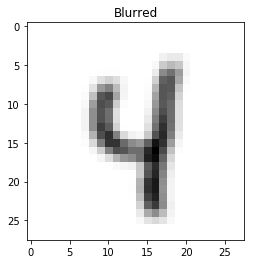

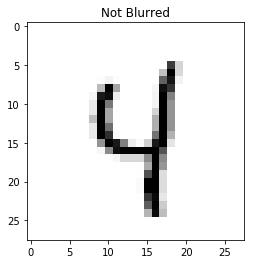

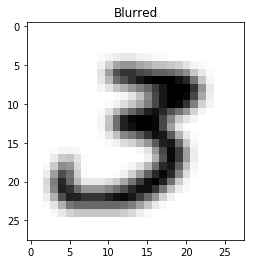

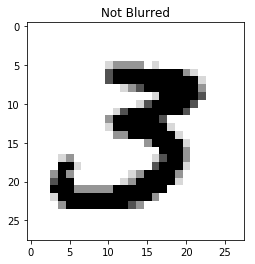

In [10]:
# // test if blur worked
for i in range(2):
    use_matrix = np.reshape(blur_dev_data[i], (28, 28))
    fig = plt.figure()
    plt.imshow(use_matrix, cmap='Greys')
    plt.title('Blurred')
    use_matrix = np.reshape(dev_data[i], (28, 28))
    fig = plt.figure()
    plt.imshow(use_matrix, cmap='Greys')
    plt.title('Not Blurred')

In [11]:
# // no preprocess done to either the training or dev data
knn = KNeighborsClassifier(n_neighbors=1)
# // instantiate a training set for algorithm learning, which varies on size based on how much is training data is desired
knn.fit(mini_train_data, mini_train_labels)
# // get the prediction out using KNeighborsClassifier function in scipy and save the predicted labels
label_prediction = knn.predict(dev_data)
# // check how many labels are correct
correct = sum(label_prediction==dev_labels)
# // make a fraction correct divided total length of labels for an accuracy ratio
accuracy = float(correct) / len(dev_labels)
print "Training Set: No Blur and Test Set: No Blur : the accuracy ratio is : " + str(accuracy)

# // preprocess the training data but not the dev data
knn = KNeighborsClassifier(n_neighbors=1)
# // instantiate a training set for algorithm learning, which varies on size based on how much is training data is desired
knn.fit(blur_train_data, mini_train_labels)
# // get the prediction out using KNeighborsClassifier function in scipy and save the predicted labels
label_prediction = knn.predict(dev_data)
# // check how many labels are correct
correct = sum(label_prediction==dev_labels)
# // make a fraction correct divided total length of labels for an accuracy ratio
accuracy = float(correct) / len(dev_labels)
print "Training Set: Yes Blur and Test Set: No Blur : the accuracy ratio is : " + str(accuracy)

# // preprocess the dev data but not the training data
knn = KNeighborsClassifier(n_neighbors=1)
# // instantiate a training set for algorithm learning, which varies on size based on how much is training data is desired
knn.fit(mini_train_data, mini_train_labels)
# // get the prediction out using KNeighborsClassifier function in scipy and save the predicted labels
label_prediction = knn.predict(blur_dev_data)
# // check how many labels are correct
correct = sum(label_prediction==dev_labels)
# // make a fraction correct divided total length of labels for an accuracy ratio
accuracy = float(correct) / len(dev_labels)
print "Training Set: No Blur and Test Set: Yes Blur : the accuracy ratio is : " + str(accuracy)

# // preprocess both training and dev data
knn = KNeighborsClassifier(n_neighbors=1)
# // instantiate a training set for algorithm learning, which varies on size based on how much is training data is desired
knn.fit(blur_train_data, mini_train_labels)
# // get the prediction out using KNeighborsClassifier function in scipy and save the predicted labels
label_prediction = knn.predict(blur_dev_data)
# // check how many labels are correct
correct = sum(label_prediction==dev_labels)
# // make a fraction correct divided total length of labels for an accuracy ratio
accuracy = float(correct) / len(dev_labels)
print "Training Set: Yes Blur and Test Set: Yes Blur : the accuracy ratio is : " + str(accuracy)

Training Set: No Blur and Test Set: No Blur : the accuracy ratio is : 0.888
Training Set: Yes Blur and Test Set: No Blur : the accuracy ratio is : 0.907
Training Set: No Blur and Test Set: Yes Blur : the accuracy ratio is : 0.871
Training Set: Yes Blur and Test Set: Yes Blur : the accuracy ratio is : 0.903


Answer: It appears that when you make the training set more generalized it benefits the algorithm when trying to find nearest neighbors in the test set. However, when you add the generalization to the test set as well as training, it appears to make things worst for these data sets on K=1. This is probably due to the blurring function and how it averages over the adjacent cells, and leads to more instances of false positives and is amplified when the test set is blurred. 

The best instance is when we blurred the training set and kept the test set in tact.

ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [12]:
def P7(dictionary):
    ### STUDENT START ###
    
    # // split data into bins (if BernoulliNB -> 0s and 1s and if MultinomialNB -> 0s, 1s, 2s)
    # // BernoulliNB the split is 0.5; MultinomialNB the splits are 0.33, 0.66
    binarized_train_data = np.digitize(mini_train_data, dictionary["input"])
    binarized_dev_data = np.digitize(dev_data, dictionary["input"])    
    
    # // if bernoulli -> fit into BernoulliNB and print accuracy
    if dictionary["type"] == 'bernoulli':
        fit = BernoulliNB(alpha=1., fit_prior=False)
        fit.fit(binarized_train_data , mini_train_labels) 
        label_prediction = fit.predict(binarized_dev_data)
        
        correct = sum(label_prediction==dev_labels)
        accuracy = float(correct) / len(dev_labels)
        print "Bernoulli binarize manipulation of data - the accuracy ratio is : " + str(accuracy)
    
    # // if multinomial -> fit into MultinomialNB and print accuracy
    elif dictionary["type"] == 'multinomial':
        fit = MultinomialNB(alpha=1., fit_prior=False)
        fit.fit(binarized_train_data , mini_train_labels) 
        label_prediction = fit.predict(binarized_dev_data)
        
        correct = sum(label_prediction==dev_labels)
        accuracy = float(correct) / len(dev_labels)
        print "Multinomial manipulation of data - the accuracy ratio is : " + str(accuracy)
    return 

# // fit into normal for comparison
fit = KNeighborsClassifier(n_neighbors=1)
fit.fit(mini_train_data , mini_train_labels) 
label_prediction = fit.predict(dev_data)
correct = sum(label_prediction==dev_labels)
accuracy = float(correct) / len(dev_labels)
print "No binary manipulation of data - the accuracy ratio is : " + str(accuracy)
        
P7(dict([("type", "bernoulli"),("input", [0.5])]))

P7(dict([("type", "multinomial"),("input", [0.33, 0.66])]))
### STUDENT END ###


# // run def: P7(dictionary)
# // Input : dictionary = a dictionary of what type of model and where the splits are to normalize the data
# // Output: Prints out information on the various models fitted vs predicted accruacy information for comparison

No binary manipulation of data - the accuracy ratio is : 0.888
Bernoulli binarize manipulation of data - the accuracy ratio is : 0.815
Multinomial manipulation of data - the accuracy ratio is : 0.801


Answer:
The binary class returns a lower accuracy than the no manipulation to the data. The multi-class version returns an even lower accuracy of prediction than the binary variable case. We essentially made the predictions harder to match the actual labels because we made more of the training cases more similar to each other, harder to distinct between different digits. In other words, we started smearing all the digits into each other by simplifying the matrixes of individual digits.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [13]:
def P8(alphas):

    ### STUDENT START ###
    # // choose an estimator: BernoulliNB with bin 0.5
    estimator = BernoulliNB(binarize = .5, fit_prior=False)
    # // to perform a search over values of alpha
    gs_cv = GridSearchCV(estimator, alphas)  
    # // saves information to gs_cv for information of fit for each alpha
    gs_cv.fit(mini_train_data, mini_train_labels)
    return gs_cv

# // different parameter values for alpha out 
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

# // prints out fit information 
for row in nb.grid_scores_:
    print row

    # // prints out fit best parameter 
print "\n"
print "Best parameter = " + str(nb.best_params_['alpha'])

# // run def: P7(alphas)
# // Input : alphas = a dictionary of what different alpha values for best model pick
# // Output: Prints out information of predicted accruacy information on the various models fitted with various alphas for comparison
### STUDENT END ###

C:\Users\mgruz\Anaconda2\lib\site-packages\sklearn\naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\mgruz\Anaconda2\lib\site-packages\sklearn\naive_bayes.py:820: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))


mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}
mean: 0.81700, std: 0.02076, params: {'alpha': 0.0001}
mean: 0.82000, std: 0.01868, params: {'alpha': 0.001}
mean: 0.82100, std: 0.01811, params: {'alpha': 0.01}
mean: 0.81700, std: 0.01868, params: {'alpha': 0.1}
mean: 0.80000, std: 0.01188, params: {'alpha': 0.5}
mean: 0.79400, std: 0.01246, params: {'alpha': 1.0}
mean: 0.78400, std: 0.01934, params: {'alpha': 2.0}
mean: 0.72000, std: 0.02495, params: {'alpha': 10.0}


Best parameter = 0.01


Answer:

The Best parameter is alpha = 0.01, chosen by function best_params_ and verified by looking at all of the output from the alpha dictionary list. The accuracy for when alpha=0 is very low with mean accuracy value of 0.092. The low maginitude seems reasonable because this means there is no Laplace smoothing in the algorithm, limiting cases to match with. The shape of the values of mean accuracy seem reasonable because as you increase alpha you increase smoothing and there seems to be a sweet spot for this parameter before the values for accuracy mean start dropping because of over smoothing.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

GaussianNB fit accuracy ratio with raw data is = 0.621


theta values for baseline model: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
sigma values for baseline model: [[  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 ..., 
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10

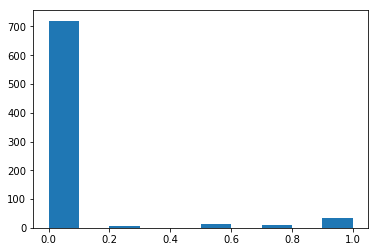

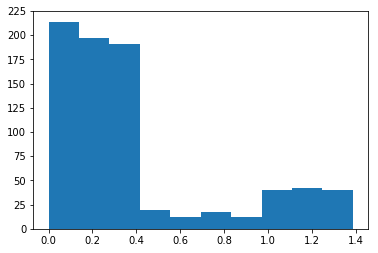

In [14]:
from scipy.ndimage import gaussian_filter
## STUDENT END ###
# // get a baseline model out for comparison
fit = GaussianNB()
fit.fit(mini_train_data, mini_train_labels) 
print "GaussianNB fit accuracy ratio with raw data is = " +  str(fit.score(dev_data, dev_labels))
print "\n"
# // plot histogram to show how poor data is for GaussianNB model
fig = plt.figure()
plt.hist(mini_train_data[0])

# // theta and sigma matrix to show how bad model is with current data
print 'theta values for baseline model: ' + str(fit.theta_)
print 'sigma values for baseline model: '  + str(fit.sigma_)

print "GaussianNB() fit is poor because the data is more binary, hence " + \
        "why the BernoulliNB has a higher accuracy ratio associated with it"
print "\n"
print "Will need to transform data in order to increase accuracy ratio with GaussianNB shown below: \n"

# // loop through input test data to "jiggle the data" to bette rbe used in GaussianNB
# // num == jiggle distance
for num in np.arange(0, 1, 0.1):
    # // instantiate an empty matrix for data overwrite
    gaussian_mini_train_data = np.zeros(mini_train_data.shape)
    # // loop through the columns
    for i in range(mini_train_data.shape[0]):
        # // loop through the rows
        for j in range(mini_train_data.shape[1]):
             # // set the data to gaussian_mini_train_data 
            gaussian_mini_train_data[i][j] = mini_train_data[i][j] + num * np.random.rand()

    # // fit "jiggled data to GaussianNB and print out accuracy ratio information
    fit = GaussianNB()
    fit.fit(gaussian_mini_train_data, mini_train_labels) 
    pediction_labels = fit.predict(dev_data)
    correct = sum(pediction_labels==dev_labels)
    accuracy = float(correct) / len(dev_labels)
    print accuracy, num

# // show an example histogram of "jiggled data"    
hist_show = np.zeros(mini_train_data.shape)
for i in range(mini_train_data.shape[0]):
    for j in range(mini_train_data.shape[1]):
        hist_show[i][j] = mini_train_data[i][j] + 0.4 * np.random.rand()
        
print "\n GaussianNB jiggle data example ploted in histogram: "
fig = plt.figure()
plt.hist(hist_show[100])

# // fit the best jiggled data again for final print
fit = GaussianNB()
fit.fit(hist_show, mini_train_labels) 
pediction_labels = fit.predict(dev_data)
correct = sum(pediction_labels==dev_labels)
accuracy = float(correct) / len(dev_labels)
print "GaussianNB fit accuracy ratio with a little bit of random data giggle data is = " +  str(accuracy)
# // run flat code
# // Input : none, run flat
# // Output: Prints out information of predicted information on the various models fitted and best data for GaussianNB model
### STUDENT END ###

ANSWER: The data in the original training set is very similar to binary information with little spread into values other than 0 and 1. This type data will fit into a BernoulliNB model fairly well, but it is not well suited for a GaussianNB model. If you look at the  theta and sigma values they are very close to zero and point to a poor model fit when using near binary type data in a BernoulliNB model. 

Then we loop through some transformations to the data to get the data better fitted for the GaussianNB model. We find that a jiggle parameter of 0.4 is best and made new data using an equation mini_train_data[i][j] + 0.4 * np.random.rand(). The histogram of that transformed data is still not ideal for the GaussianNB, but is starting to get values in between the extremes (which is better for the GaussianNB model.

The final model accuracy ratio was around  0.82.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

Accuracy ratio of probability prediction: 1.0


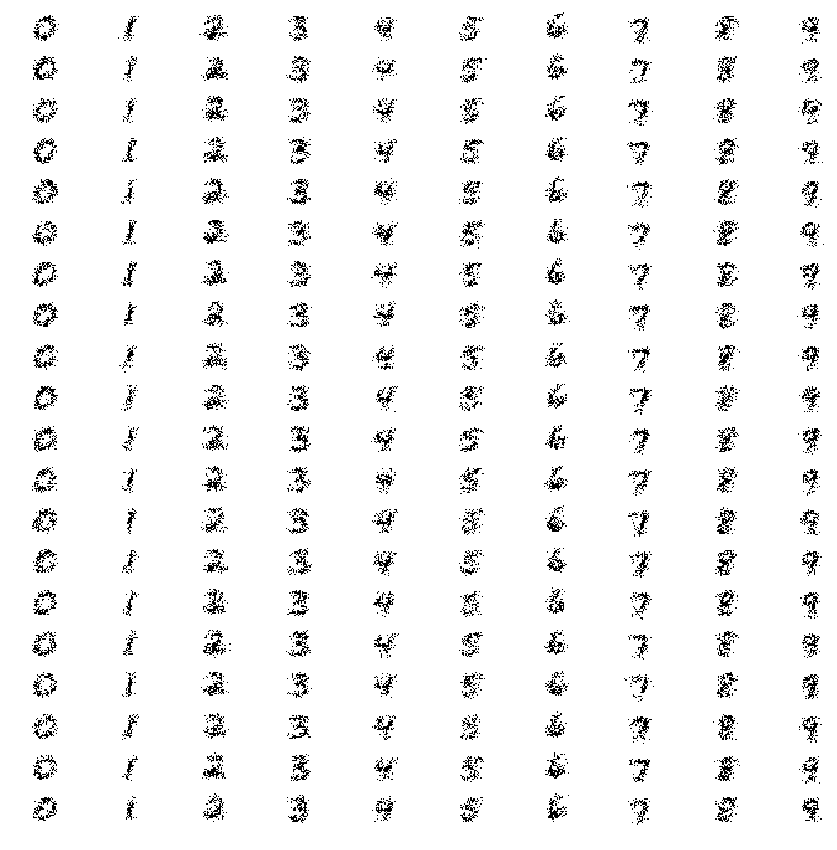

In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def P10(num_examples):

    ### STUDENT START ###
    # // make a BernoulliNB model with alpha = 0.01 (data from P8 points towards this alpha value)
    bernoulliFit = BernoulliNB(binarize = 0.5, alpha = 0.01)
    bernoulliFit.fit(mini_train_data, mini_train_labels)
    
    # // instantiate a subplot for image creation
    fig, axes = plt.subplots(nrows=num_examples, ncols=len(bernoulliFit.feature_log_prob_), figsize=(15,15))

    predict_list = []
    actual_label_list = []
    # // loop through each digit
    for digit in range(len(bernoulliFit.feature_log_prob_)):
        # // make 20 plots per digit
        for num_photos in range(num_examples):
            # // generate random numbers to make comparison with modle probability
            uniform_random_array = np.random.rand(784)
            # // get the probability of each cell for each digit and compare to the random number generated array and reshape
            # // for plotting
            temp_digit = np.exp(bernoulliFit.feature_log_prob_)[digit]
            prob_digit_creation = np.reshape([temp_digit > uniform_random_array], (28,28))
            
            # // get a prediction from the generated probability matrix and append it to the list predict_list
            predict_list.append(int(bernoulliFit.predict(temp_digit)[0]))
            # // keep track of actual digits being probabilitically generated
            actual_label_list.append(digit)
            
            # // plot each digit num_examples
            axes[num_photos][digit].imshow(prob_digit_creation, cmap='Greys')
            axes[num_photos][digit].axis('off')
            
    # // calculate the accuracy ratio
    correct = sum(np.array(predict_list)==np.array(actual_label_list))
    accuracy = float(correct) / len(actual_label_list)
    
    print "Accuracy ratio of probability prediction: " + str(accuracy)
            
    return

### STUDENT END ###

# // run def P10(num_examples) code
# // Input : num_examples = integer of how many examples per digit
# // Output: Prints out a N x M subplot of images. N = number of unique digits in the data; M = how many images of each digit 
# // is requested (num_examples) and accuracy information of stochastics digits vs real digits
P10(20)

ANSWER: The generated digits are a lot more noisy than the training digits This is due to getting a probability of each digit  based on the training set and getting locations of pixels based on a normalized density function and create the image. There is a lot of intrinsic noise in the algorithm. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [16]:
import sys

def P11(buckets, correct, total):

    ### STUDENT START ###
    # // make a BernoulliNB model with alpha = 0.01 (data from P8 points towards this alpha value)
    bernoulliFit = BernoulliNB(binarize = 0.5, alpha = 0.01)
    bernoulliFit.fit(mini_train_data, mini_train_labels)
    # // get the probability of each digit per each test prediction
    digit_prob_per_prediction = bernoulliFit.predict_proba(dev_data)
    # // get the maximum probability value per each test prediction digit
    digit_max_prob_prediction = np.amax(digit_prob_per_prediction, axis=1)
    # // bin each maximum probability of each test prediction digit and subtract by one to get it shifted back into
    # // python iteration format (0 to 8 instead of 1 through 9)
    bin_bucket_total = np.digitize(digit_max_prob_prediction, buckets) - 1
    
    # // add 1 to a bucket ([0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0])
    # // if it occurs in bin_bucket_total
    for i in bin_bucket_total:
        total[i] += 1
    
    # // get the the index (corresponds to the digit) out from the maximum value of all predictions
    digit_prediction = np.argmax(digit_prob_per_prediction, axis=1)
    # // check if the digits match the value of the actual digit labels
    correct_labels = digit_prediction == dev_labels
    # // if match then the probability is the maximum probability value per each test prediction digit
    # // if the labels dont match then the probability is set to zero
    digit_prediction_prob = correct_labels * digit_max_prob_prediction
    # // bin each maximum probability of each test prediction digit (with correctness factor) and subtract by 
    # // one to get it shifted back into python iteration format (0 to 8 instead of 1 through 9)
    bin_bucket_correct = np.digitize(digit_prediction_prob, buckets) - 1
    
    # // add 1 to a bucket ([0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0])
    # // if it occurs in bin_bucket_correct and is also correct. Incorrect choices are set to below zero, and ignored for
    # // aggregation
    for i in bin_bucket_correct:
        # // ignore negative (or incorrect) predictions
        if i >= 0:
            correct[i] += 1

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): 
        accuracy = float(correct[i]) / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)
    
# // run def P11(buckets, correct, total) code
# // Input : buckets == list of different max probability buckets, correct = empty list of length 8 representing 
# // buckets and is appended to if bucket is encountered and has correct prediction, total = empty list of length 8 
# // representing buckets and is appended to if bucket is encountered
# // Output: Prints prediction bucket, how many instances it occured of max proabability inside the bucket and
# // the accuracy ratio of that bucket (amount correct / total encountered in bucket)

p(pred) <= 0.5000000000000    total =  30    accuracy = 0.200
p(pred) <= 0.9000000000000    total =  86    accuracy = 0.465
p(pred) <= 0.9990000000000    total =  85    accuracy = 0.612
p(pred) <= 0.9999900000000    total =  58    accuracy = 0.690
p(pred) <= 0.9999999000000    total =  61    accuracy = 0.754
p(pred) <= 0.9999999990000    total =  73    accuracy = 0.877
p(pred) <= 0.9999999999900    total =  75    accuracy = 0.840
p(pred) <= 0.9999999999999    total =  34    accuracy = 0.882
p(pred) <= 1.0000000000000    total = 498    accuracy = 0.958


ANSWER: Looking at the above data, we see that higher posterior does not always belong to higher accuracy. Going from 0.999999999 to 0.99999999999 we actually loose some accuracy rating in our data, so one can not assume that higher posterior will always be given a higher accuracy rating. In general there is an upward trend upward, but there are localized minimums in the data. From the definitions above, we have a fairly weakly calibrated situation.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [128]:
#def P12():

### STUDENT START ###
from skimage.feature import canny
import numpy as np
from matplotlib import pyplot as plt

# paramerter used for the canny command (did a loop from 0 to 2 by 0.1 and found 1.1 is the best)
sigma_in = 1.1
# instantiate data list for converting matrix list to a hollow training matrix list (see images below)
train_data_hollow = []
# instantiate data list for converting matrix list to a hollow prediction matrix list (see images below)
predict_data_hollow = []
# loop through each digit in training set
for digit in test_data:
    img = digit.reshape(28,28)
    # perform hollow fnction on data see below
    hollow = canny(img, sigma=sigma_in)
    # append to empty list above
    train_data_hollow.append(hollow.reshape(784, ))

# Use function from question 6 to blurry up the hollow digit
blurred_train_data_hollow = P6(train_data_hollow)

# loop through each digit in prediction set
for digit in dev_data:
    img = digit.reshape(28,28)
    # perform hollow fnction on data see below
    hollow = canny(img, sigma=sigma_in)
    # append to empty list above
    predict_data_hollow.append(hollow.reshape(784, ))

# Use function from question 6 to blurry up the hollow digit
blurred_predict_data_hollow = P6(predict_data_hollow)

# fit the data and show accuracy
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(blurred_train_data_hollow, test_labels)
label_prediction = knn.predict(blurred_predict_data_hollow)
correct = sum(label_prediction==dev_labels)
accuracy = float(correct) / len(dev_labels)
print "blurred hollow train, blurred hollow predict", sigma_in, accuracy


### STUDENT END ###
#P12()

blurred hollow train, blurred hollow predict 1.1 0.935


Above shows that this algorithm accuracy predicts 0.935 when a larger training set is used and 0.883 when the smaller mini_train_set is used, which is larger than the results from Naive-Bayes in question P7

In [130]:
#def P12():

### STUDENT START ###
from skimage.feature import canny
import numpy as np
from matplotlib import pyplot as plt

# paramerter used for the canny command (did a loop from 0 to 2 by 0.1 and found 1.1 is the best)
sigma_in = 1.1
# instantiate data list for converting matrix list to a hollow training matrix list (see images below)
train_data_hollow = []
# instantiate data list for converting matrix list to a hollow prediction matrix list (see images below)
predict_data_hollow = []
# loop through each digit in training set
for digit in mini_train_data:
    img = digit.reshape(28,28)
    # perform hollow fnction on data see below
    hollow = canny(img, sigma=sigma_in)
    # append to empty list above
    train_data_hollow.append(hollow.reshape(784, ))

# Use function from question 6 to blurry up the hollow digit
blurred_train_data_hollow = P6(train_data_hollow)

# loop through each digit in prediction set
for digit in dev_data:
    img = digit.reshape(28,28)
    # perform hollow fnction on data see below
    hollow = canny(img, sigma=sigma_in)
    # append to empty list above
    predict_data_hollow.append(hollow.reshape(784, ))

# Use function from question 6 to blurry up the hollow digit
blurred_predict_data_hollow = P6(predict_data_hollow)

# fit the data and show accuracy
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(blurred_train_data_hollow, mini_train_labels)
label_prediction = knn.predict(blurred_predict_data_hollow)
correct = sum(label_prediction==dev_labels)
accuracy = float(correct) / len(dev_labels)
print "blurred hollow train, blurred hollow predict", sigma_in, accuracy


### STUDENT END ###
#P12()

blurred hollow train, blurred hollow predict 1.1 0.883


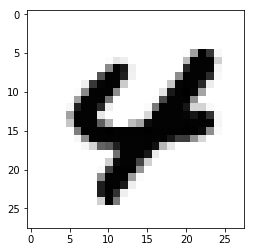

In [82]:
# normal digit plot
plt.imshow(test_data[20].reshape(28, 28), cmap='Greys')

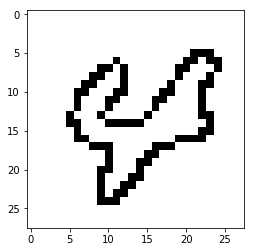

In [81]:
# hollow digit plot
plt.imshow(test_data_hollow[20].reshape(28, 28), cmap='Greys')

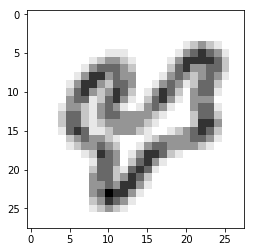

In [79]:
# blurred hollow digit plot
plt.imshow(output_matrix[20].reshape(28, 28), cmap='Greys')